In [ ]:
%pip install scikit-allel seaborn pandas pysam tqdm numpy

In [1]:
import allel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pysam import VariantFile
from tqdm import tqdm
import numpy as np

In [77]:
igsr_pop = pd.read_csv("igsr_populations.tsv", sep="\t")

In [2]:
vcf_dir = "data/1000G/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz"
pruned_vcf_dir = "data/processed/chr22_pruned.vcf"
def allele_indices(vcf_dir, skip_every = 5):
    """
    Given a VCF file, this returns each samples genotype 
    represented as allele indices along with the corresponding
    variant IDs and list of samples.

    Args:
        vcf_dir (string): Location of VCF file.
        skip_every (int): Only return every other "skip_every"
            variant. This may be useful if you are running this
            with less than 16GB of RAM.

    Returns:
        list: List of each sample.
        list: Genotypes of shape: (samples, num_variants // skip_every, 2).
        list: Variant IDs for each variant.

    """
    vcf_file = VariantFile(vcf_dir)

    samples = list(vcf_file.header.samples)

    genotypes = []
    variant_ids = []
    for counter, record in tqdm(enumerate(vcf_file.fetch())):
        if counter % skip_every == 0:
            alleles = [record.samples[x].allele_indices for x in samples]

            genotypes.append(alleles)
            variant_ids.append(record.id)

    return samples, genotypes, variant_ids

In [3]:
panel_dir = "data/1000G/integrated_call_samples_v3.20130502.ALL.panel"
def parse_panel(panel_dir):
    """
    Returns python dictionaries that maps each sample
    to a population and superpopulation. 

    Args:
        panel_dir (string): Location of the panel file 
            containing information about each sample.

    Returns:
        dict: Population map for each sample. For
            example, {sample_id, population}.

        dict: Superpopulation map for each sample. For
            example, {sample_id, superpopulation}.

    """
    population_map = {}  
    superpopulation_map = {}  
    with open(panel_dir) as panel_file:
        for sample in panel_file:
            """
            EX: ["HG00607", "CHS", "ASN", "ILLUMINA"]

            sample[0] = Sample ID.
            sample[1] = Population.
            sample[2] = Superpopulation.

            """
            sample = sample.strip().split('\t')

            population_map[sample[0]] = sample[1]
            superpopulation_map[sample[0]] = sample[2]
    
    return population_map, superpopulation_map 

In [ ]:
skip_every = 25
samples, genotypes, variant_ids = allele_indices(vcf_dir, skip_every)
population_map, superpopulation_map = parse_panel(panel_dir)
superpopulation = pd.Series(samples).map(superpopulation_map)
genotypes = np.array(genotypes)


1103547it [01:05, 16866.61it/s]


In [6]:
genotypes.shape

(44142, 2504, 2)

In [7]:


genotype_array = allel.GenotypeArray(genotypes)
genotype_array


<GenotypeArray shape=(44142, 2504, 2) dtype=int64>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [8]:
allele_count = genotype_array.count_alleles()
allele_count

<AlleleCountsArray shape=(44142, 5) dtype=int32>
5007    1    0    0    0
5007    1    0    0    0
5007    1    0    0    0
...
5007    1    0    0    0
4662  346    0    0    0
5007    1    0    0    0

In [141]:
genotypes = np.sum(genotypes, axis = 2)

In [9]:
df_allele_count = pd.DataFrame(allele_count)

genotype_count = {
    k : df_allele_count.loc[df_allele_count[k]!=0].shape[0]/df_allele_count.shape[0] * 100 for k in df_allele_count.columns
}
print(f"Pourcentage où le génotype est présent : {genotype_count}")

Pourcentage où le génotype est présent : {0: 99.9343029314485, 1: 99.71002673191065, 2: 0.5958044492773322, 3: 0.03171582619727244, 4: 0.002265416156948031}


We can notice that genotypes 2 and 3 and 4 are highly negligeable compared 0 and 1 in the dataset so we will be using the n_alt for our cells instead of the genotype

$ n_{alt} = \mathbb{1}_{\{\text{genotype}_0 = 0\}} + \mathbb{1}_{\{\text{genotype}_1 = 0\}} $ \
\
e.g if the genotype is <0,1> then $ n_{alt} = 1 $ if it's <1,1> it's 2, if it's <4,3> it's 2, if it's <0,0> it's 0 and so on

In [10]:
geno_n_alt = genotype_array.to_n_alt(fill=-1)
geno_n_alt

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [11]:
geno_n_alt.shape

(44142, 2504)

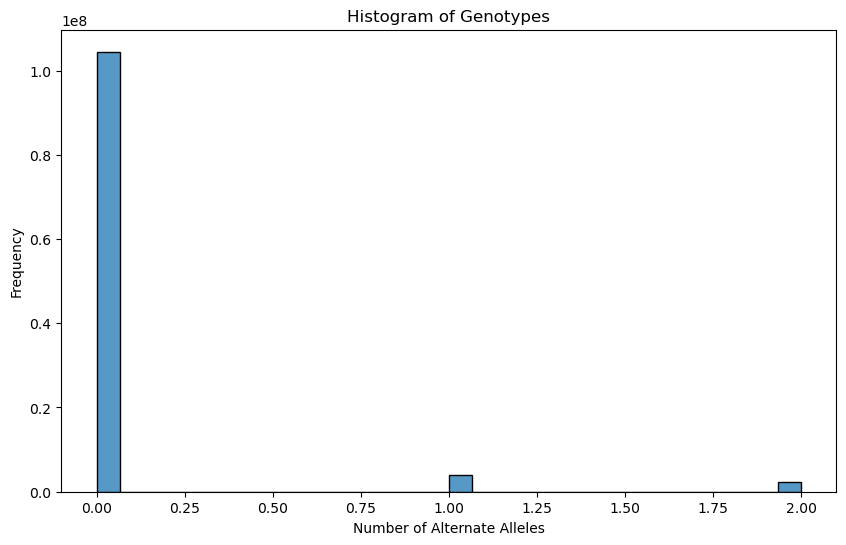

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(geno_n_alt.flatten(), bins=30, kde=False)
plt.title("Histogram of Genotypes")
plt.xlabel("Number of Alternate Alleles")
plt.ylabel("Frequency")
plt.show()

In [13]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
genotypes_scaled = scaler.fit_transform(geno_n_alt)

In [14]:
m, n = geno_n_alt.shape

print(f"Shape: ({m}, {n})")
print(f"New Number of Obervations: {m}")
print(f"New Number of Features: {n}")
print(f"{geno_n_alt}")

Shape: (44142, 2504)
New Number of Obervations: 44142
New Number of Features: 2504
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
smaller_geno = geno_n_alt[::5]

In [19]:
# Calculate the mean.
geno_to_study = smaller_geno
mean = np.mean(geno_to_study, axis = 1, keepdims = True)

# Subtract the mean.
genotypes_normalized = geno_to_study - mean

# Compute the covariance matrix of our data.
covariance = genotypes_normalized.dot(genotypes_normalized.T) / (n - 1)

eig_values, eig_vectors = np.linalg.eigh(covariance)

# They are in ascending order, we want the opposite.
eig_values = eig_values[::-1]
eig_vectors = eig_vectors[:, ::-1]

print(eig_values.shape)
print(eig_vectors.shape)

np.cumsum(eig_values / np.sum(eig_values))[0 : 10]

pc1 = eig_vectors[:, 0]
pc2 = eig_vectors[:, 1]

pc1_plot = genotypes_normalized.T.dot(pc1)
pc2_plot = genotypes_normalized.T.dot(pc2)

(8829,)
(8829, 8829)


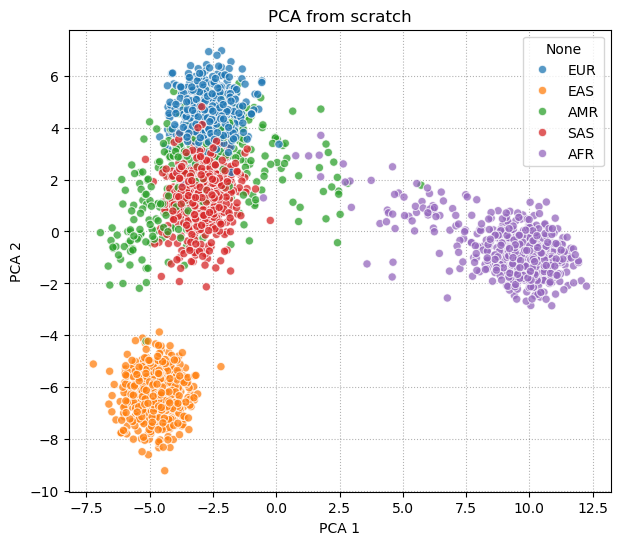

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (7, 6))

sns.scatterplot(
    x = pc1_plot, 
    y = pc2_plot, 
    hue = superpopulation,
    alpha = 0.75, 
    zorder = 2,
    linewidth = 0.75,
    ax = ax
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)
plt.title('PCA from scratch')
plt.show()

In [123]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 26)
kmeans.fit(genotypes_normalized.T)
clusters = kmeans.predict(genotypes_normalized.T)

population = [k for k in population_map.values() if k != "pop"]
df_clusters = pd.DataFrame(clusters, columns = ["Cluster"])
df_clusters["Superpopulation"] = superpopulation
df_clusters["Population"] = population
df_clusters['Pop_label'] = df_clusters['Population'].apply(lambda x: igsr_pop[igsr_pop['Population code'] == x]['Population name'].values[0] + "["+ igsr_pop[igsr_pop['Population code'] == x]['Superpopulation code'].values[0] + "]")
df_clusters.sort_values(by="Superpopulation", inplace=True)

In [124]:
df_clusters

,Cluster,Superpopulation,Population,Pop_label
1251,17,AFR,ESN,Esan[AFR]
2083,25,AFR,YRI,Yoruba[AFR]
2084,25,AFR,YRI,Yoruba[AFR]
2085,12,AFR,YRI,Yoruba[AFR]
2086,5,AFR,YRI,Yoruba[AFR]
...,...,...,...,...
1398,19,SAS,PJL,Punjabi[SAS]
1397,13,SAS,STU,Tamil[SAS]
1396,19,SAS,STU,Tamil[SAS]
1405,1,SAS,ITU,Telugu[SAS]


In [130]:

superpop_order = ["AFR", "AMR", "EAS", "EUR", "SAS"]
pop_label_order = df_clusters.sort_values(by=["Superpopulation", "Pop_label"])["Pop_label"].unique().tolist()
df_clusters_sorted = df_clusters.sort_values(by=["Superpopulation", "Cluster"])


In [89]:
pops_seen = set()
for pop in population:
    if pop not in pops_seen:
        pops_seen.add(pop)

print(len(pops_seen))

26


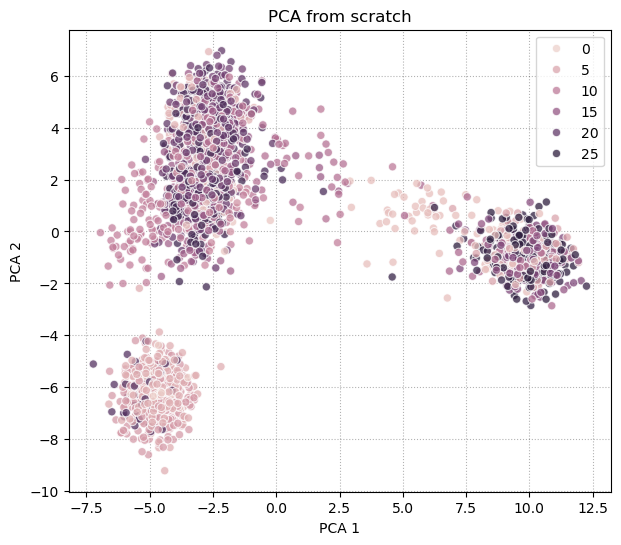

In [131]:

fig, ax = plt.subplots(1, 1, figsize = (7, 6))

sns.scatterplot(
    x = pc1_plot, 
    y = pc2_plot, 
    hue = clusters,
    alpha = 0.75, 
    zorder = 2,
    linewidth = 0.75,
    ax = ax
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)
plt.title('PCA from scratch')
plt.show()




<Axes: xlabel='Superpopulation', ylabel='Cluster'>

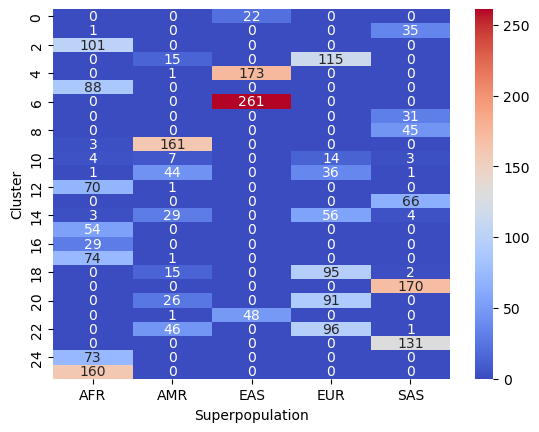

In [132]:
import seaborn as sns
sns.heatmap(pd.crosstab(df_clusters["Cluster"], df_clusters["Superpopulation"]), cmap = "coolwarm", annot = True, fmt='d')

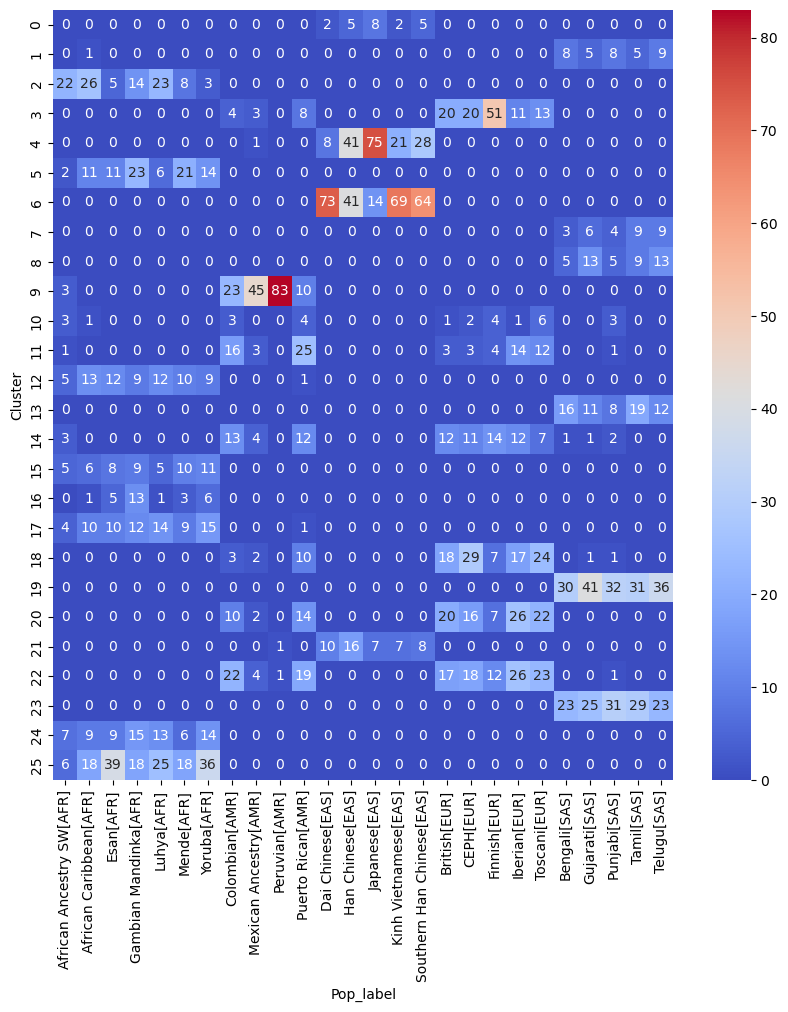

In [135]:
plt.figure(figsize=(10, 10))
crosstab = pd.crosstab(df_clusters["Cluster"], df_clusters["Pop_label"])
crosstab = crosstab[pop_label_order]
sns.heatmap(crosstab, cmap = "coolwarm", annot = True, fmt='d')
plt.show()

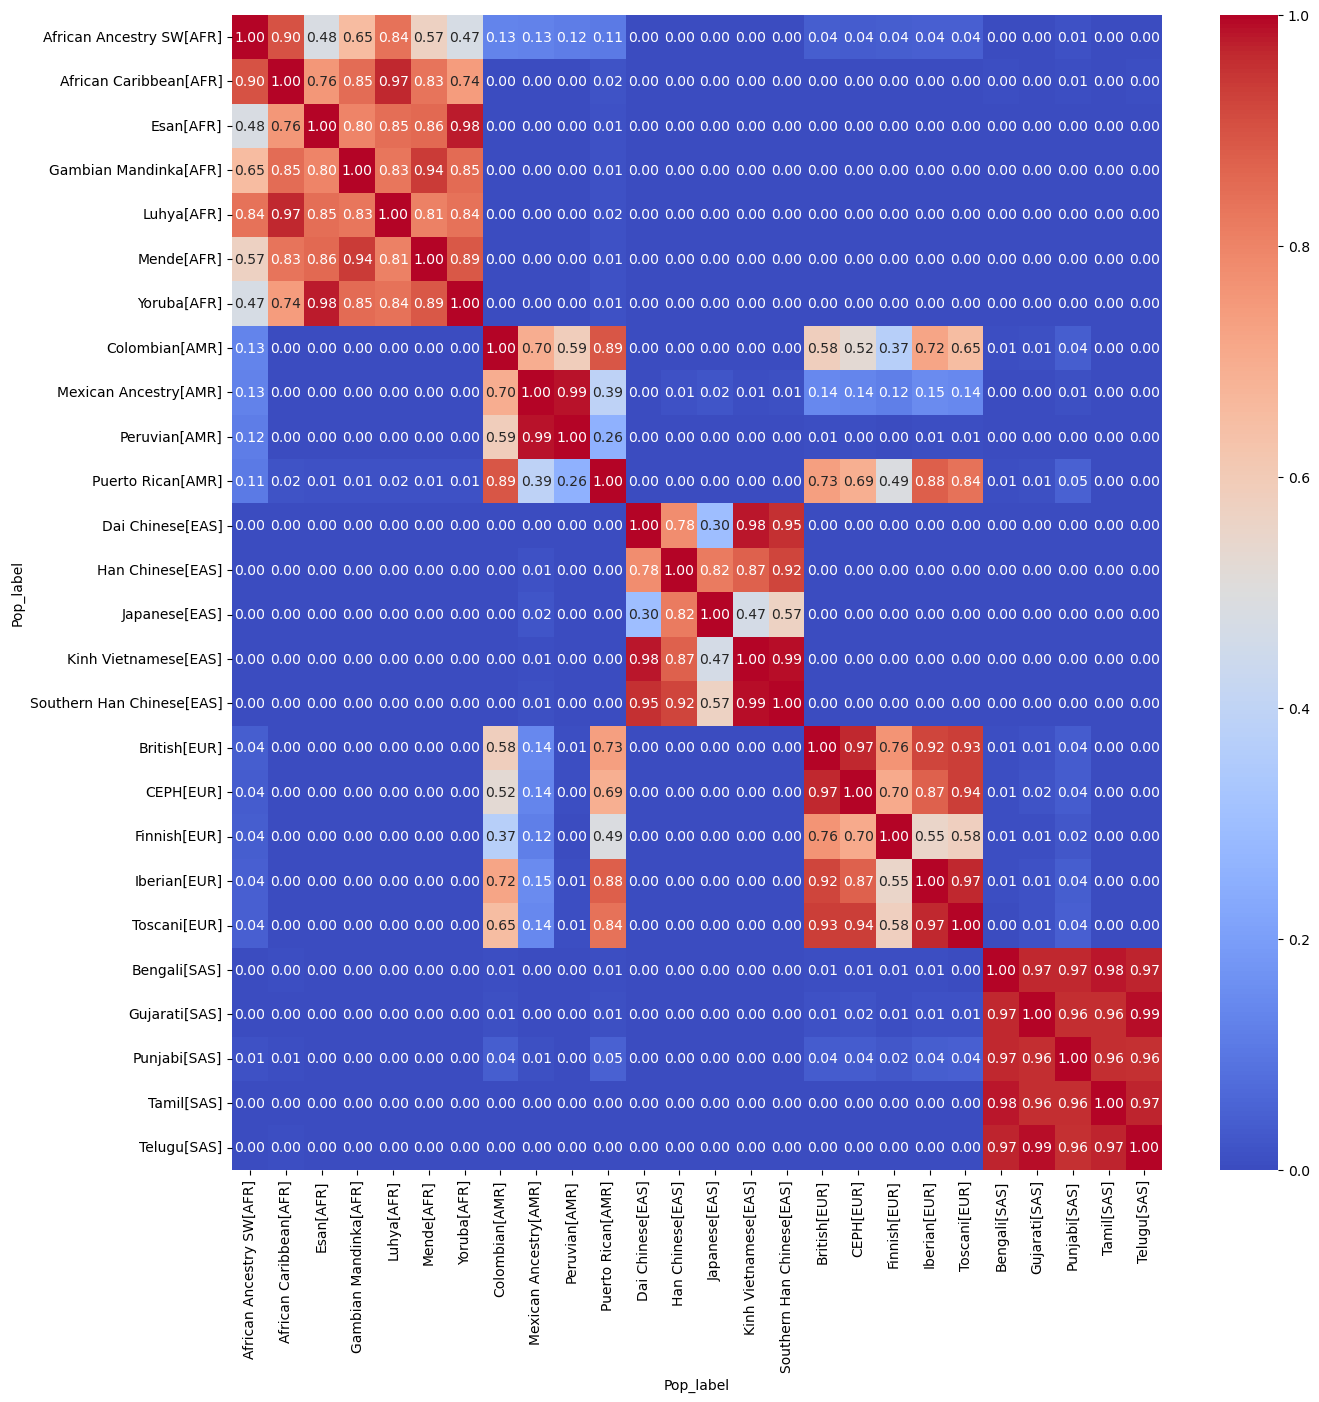

In [139]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix_pop = cosine_similarity(crosstab.T)
similarity_df_pop = pd.DataFrame(similarity_matrix_pop, index=crosstab.columns, columns=crosstab.columns)
plt.figure(figsize=(15, 15))
sns.heatmap(similarity_df_pop, cmap = "coolwarm", annot = True, fmt='.2f')
plt.show()

### Cumulative variance plot

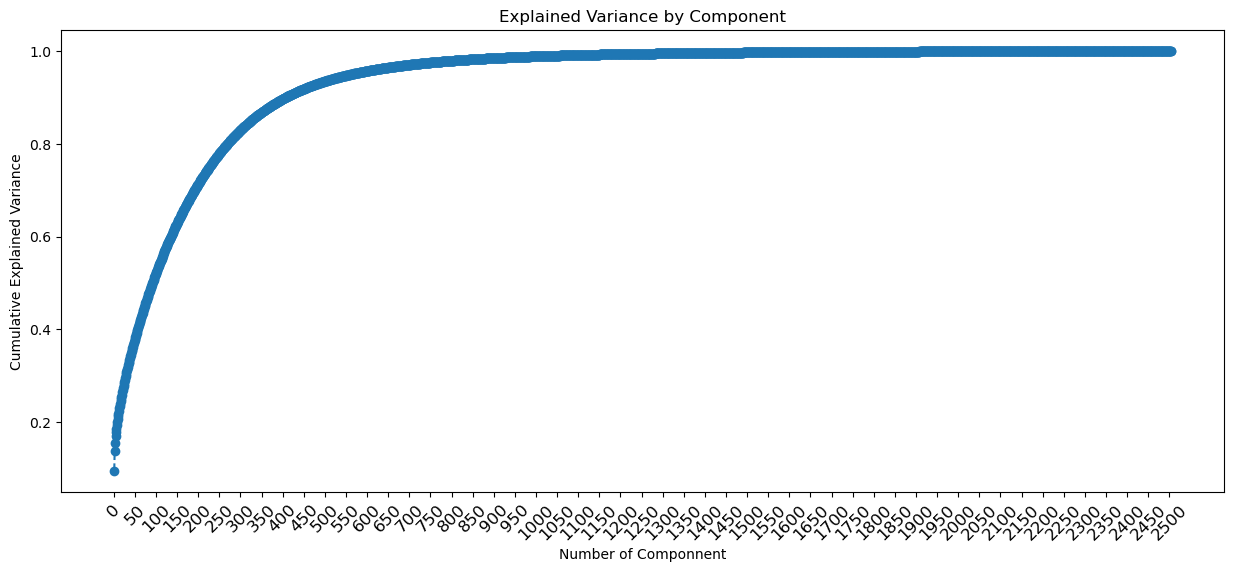

In [ ]:
from sklearn.decomposition import PCA

smaller_geno = genotypes[::10]
genotypes = genotypes[::10]
pca_model = PCA()
pca_model.fit(smaller_geno.T)

explained_variance = pca_model.explained_variance_ratio_

plt.figure(figsize=(15,6))
plt.plot(range(1,2505), explained_variance.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Component')
plt.xlabel('Number of Componnent')
plt.ylabel('Cumulative Explained Variance')

plt.xticks(fontsize=12)
plt.xticks(range(0, 2505, 50))
plt.tick_params(axis='x', rotation=45)

plt.show()

Therefore, the rule of thumb is to perserve around 80% of the variance. So, we decide to keep 275 components.
#what threshold should we take? 80% or 95%?

In [143]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components = 275)
pca_model.fit(genotypes.T)
reduce_data_pca = pca_model.fit_transform(genotypes.T)

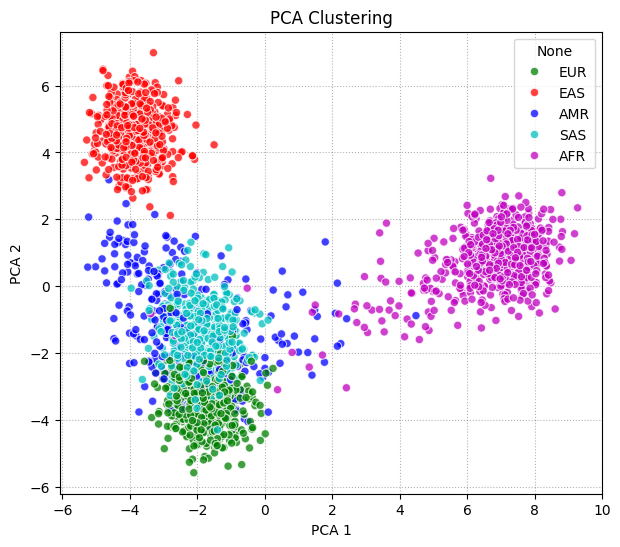

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7, 6))
sns.scatterplot(
    x = reduce_data_pca[:, 0],
    y = reduce_data_pca[:, 1], 
    hue = superpopulation, 
    palette=['g', 'r', 'b', 'c', 'm'],
    alpha = 0.75, 
    zorder = 2,
    linewidth = 0.75,
    ax = ax
)
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)
plt.title("PCA")
plt.show()

In [14]:
variance_captured = np.cumsum(pca_model.explained_variance_ratio_)[-1]
print(f"Percentage of variance captured with {pca_model.n_components} components: {variance_captured:0.4f}")

Percentage of variance captured with 275 components: 0.8036


### Elbow Method

/home/tmenghor/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tmenghor/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tmenghor/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tmenghor/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

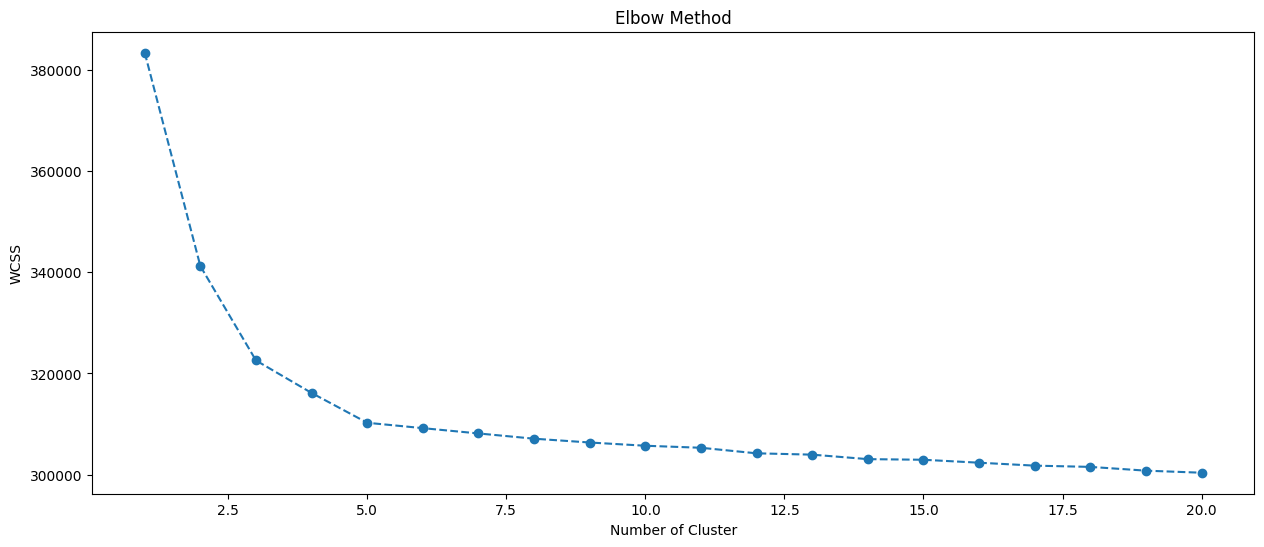

In [ ]:
from sklearn.cluster import KMeans
pca_model = PCA(n_components=275)
pca_model.fit(genotypes.T)
scores_pca = pca_model.transform(genotypes.T)

wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(15,6))
plt.plot(range(1,21), wcss, marker='o', linestyle = '--')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

### Kmeans without pca

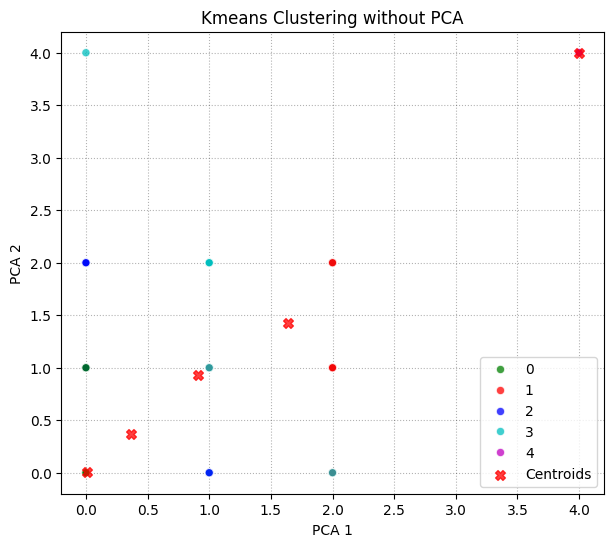

In [ ]:
cluster_model = KMeans(n_clusters = 5, max_iter = 10000, n_init = 25, random_state=5)
kmeans_labels = cluster_model.fit_predict(genotypes)

# centers = cluster_model.cluster_centers_
centers_reduced = cluster_model.cluster_centers_

fig, ax = plt.subplots(1, 1, figsize = (7, 6))
sns.scatterplot(
    x = genotypes[:, 0], 
    y = genotypes[:, 1], 
    hue = kmeans_labels, 
    palette=['g', 'r', 'b', 'c', 'm'],
    alpha = 0.75, 
    zorder = 2,
    linewidth = 0.75,
    ax=ax
)

plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1], c='red', s=50, alpha=0.75, marker='X', label='Centroids', zorder=3 )

# ax.set_xlabel("PCA 1")
# ax.set_ylabel("PCA 2")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)
plt.title("Kmeans Clustering without PCA")
plt.legend()
plt.show()

### Kmeans with PCA

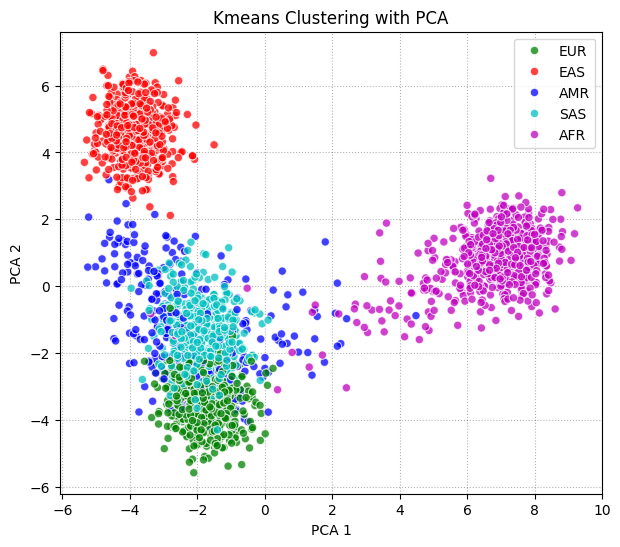

In [ ]:
from sklearn.cluster import KMeans

pca_model = PCA(n_components = 275)
reduced_data_pca = pca_model.fit_transform(genotypes.T)

kmeans_model = KMeans(n_clusters = 5, max_iter = 10000, n_init = 25, random_state=5)
kmeans_labels = kmeans_model.fit_predict(reduced_data_pca)

fig, ax = plt.subplots(1, 1, figsize = (7, 6))
sns.scatterplot(
    x = reduced_data_pca[:, 0], 
    y = reduced_data_pca[:, 1], 
    hue = superpopulation,
    palette=['g', 'r', 'b', 'c', 'm'],
    alpha = 0.75, 
    zorder = 2,
    linewidth = 0.75,
    ax = ax
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)
plt.title("Kmeans Clustering with PCA")
plt.legend()
plt.show()


#### Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
labels = kmeans_model.labels_
sil_score = silhouette_score(genotypes.T, labels)
print(f"Silhouette Score: {sil_score:.4f}")
dbi = davies_bouldin_score(genotypes.T, labels)
print(f"Davies-Bouldin Index: {dbi:.4f}")

Silhouette Score: 0.0532
Davies-Bouldin Index: 4.0802


clusters are poorly separated

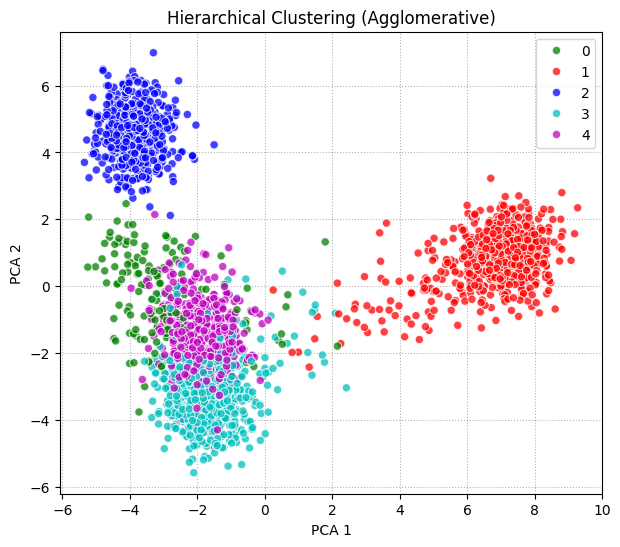

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

reduced_data_pca = pca_model.fit_transform(genotypes.T)

hierarchical_model = AgglomerativeClustering(n_clusters=5, linkage='ward')
hierarchical_labels = hierarchical_model.fit_predict(reduced_data_pca)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

sns.scatterplot(
    x=reduced_data_pca[:, 0],
    y=reduced_data_pca[:, 1],
    hue=hierarchical_labels,
    palette=['g', 'r', 'b', 'c', 'm'],
    alpha=0.75, 
    zorder=2,
    linewidth=0.75,
    ax=ax
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha=0.3, color="black", linestyle="dotted", zorder=1)

plt.title("Hierarchical Clustering (Agglomerative)")
plt.show()

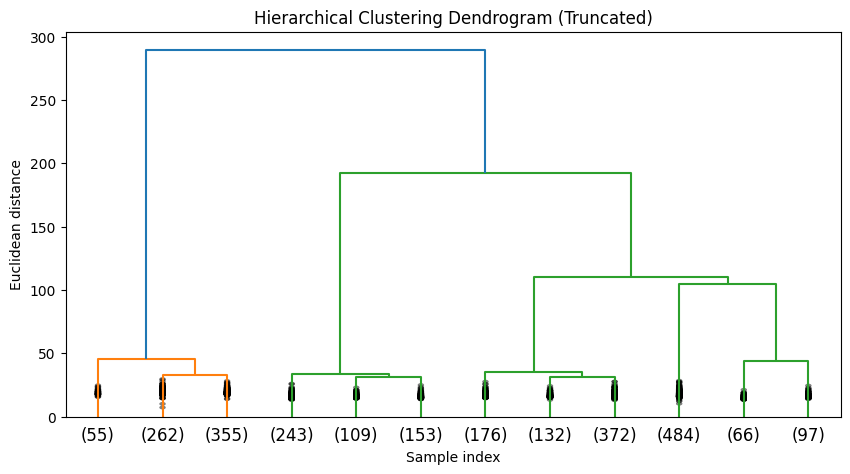

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage


Z = linkage(genotypes.T, 'ward')

plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=12, show_leaf_counts=True, show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')
plt.show()

In [ ]:
labels = hierarchical_model.labels_
sil_score = silhouette_score(genotypes.T, labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.0520


### Chosing Min. Samples and Epsilon

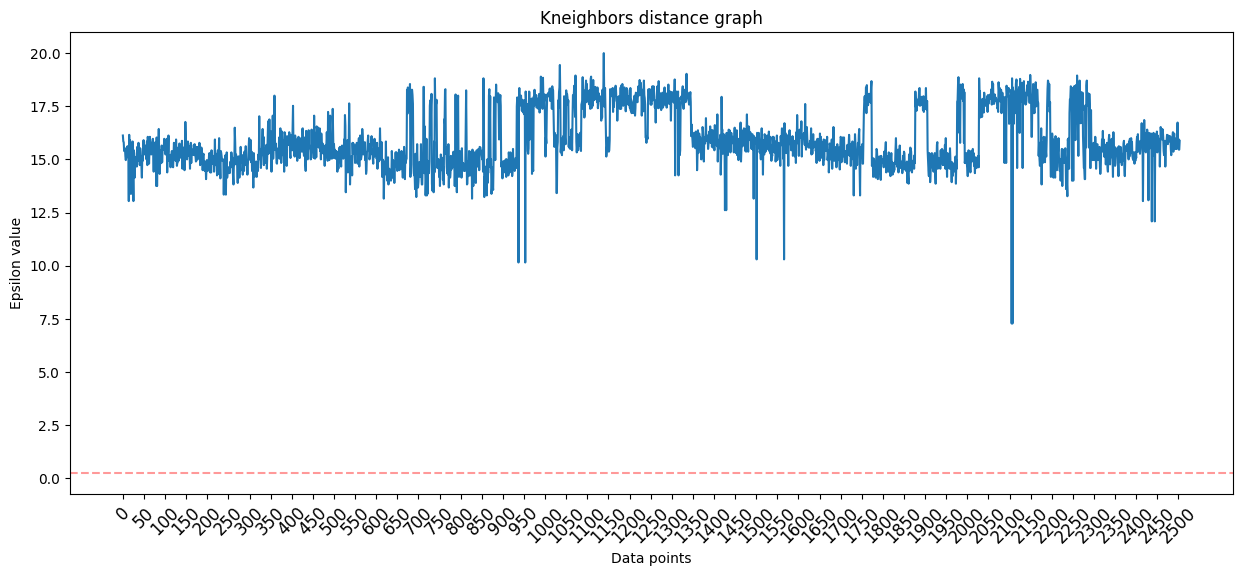

In [ ]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=2503)
nbrs = nn.fit(genotypes.T)
distances, indices = nbrs.kneighbors(genotypes.T)

istances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(15,6))
plt.plot(distances)
plt.axhline(y=0.24, color='r', linestyle='--', alpha=0.4)
plt.title('Kneighbors distance graph')
plt.xlabel('Data points')
plt.ylabel('Epsilon value')
plt.xticks(fontsize=12)
plt.xticks(range(0, 2505, 50))
plt.tick_params(axis='x', rotation=45)
plt.show()

### BDSCAN

/tmp/ipykernel_47621/858145724.py:12: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


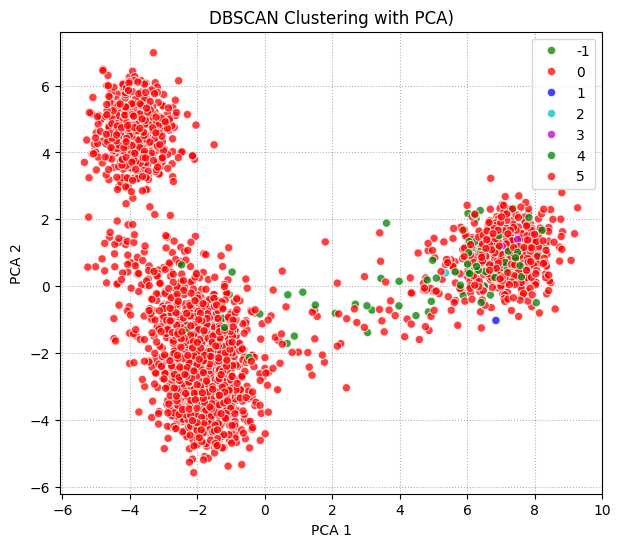

In [ ]:
from sklearn.cluster import DBSCAN

reduced_data_pca = pca_model.fit_transform(genotypes.T)

dbscan_model = DBSCAN(eps=14.72, min_samples=2)
dbscan_labels = dbscan_model.fit_predict(reduced_data_pca)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

sns.scatterplot(
    x=reduced_data_pca[:, 0],
    y=reduced_data_pca[:, 1],
    hue=dbscan_labels,
    palette=['g', 'r', 'b', 'c', 'm'],
    alpha=0.75, 
    zorder=2,
    linewidth=0.75,
    ax=ax
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha=0.3, color="black", linestyle="dotted", zorder=1)

plt.title("DBSCAN Clustering with PCA)")

plt.show()

In [ ]:
dbscan_model.fit(genotypes.T)
labels = dbscan_model.labels_

genotypes_T = pd.DataFrame(genotypes.T)
genotypes_T['labels'] = labels

genotypes_T.head()

labels_list = list(genotypes_T['labels'])
n_noise = labels_list.count(-1)
print("Number of noise points:", n_noise)

Number of noise points: 2125


In [30]:
total_labels = np.unique(labels)

n_labels = 0
for n in total_labels:
    if n != -1:
        n_labels += 1
print("Number of clusters:", n_labels)

Number of clusters: 38


In [31]:
from sklearn.metrics import silhouette_score

s_score = silhouette_score(genotypes_T, labels)
print(f"Silhouette coefficient: {s_score:.3f}")

Silhouette coefficient: -0.040


### Spectral clustering

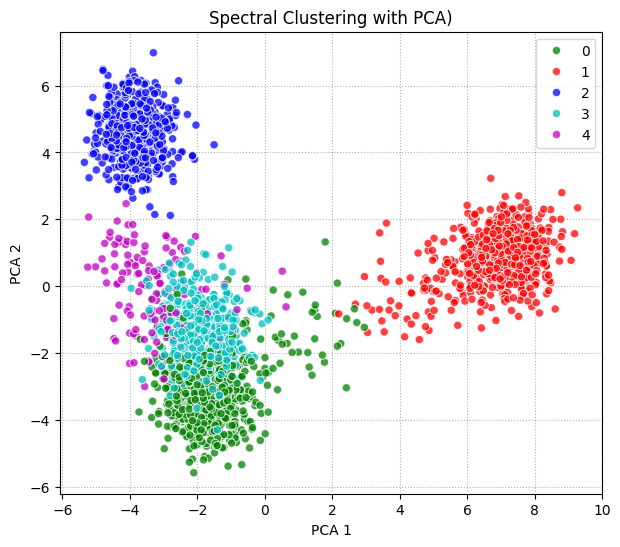

In [ ]:
from sklearn.cluster import SpectralClustering 

reduced_data_pca = pca_model.fit_transform(genotypes.T)

spectral_model = SpectralClustering(n_clusters = 5, affinity ='nearest_neighbors', n_init = 10)

spectral_labels = spectral_model.fit_predict(reduced_data_pca)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

sns.scatterplot(
    x=reduced_data_pca[:, 0],
    y=reduced_data_pca[:, 1],
    hue=spectral_labels,
    palette=['g', 'r', 'b', 'c', 'm'],
    alpha=0.75, 
    zorder=2,
    linewidth=0.75,
    ax=ax
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha=0.3, color="black", linestyle="dotted", zorder=1)

plt.title("Spectral Clustering with PCA)")

plt.show()

In [ ]:
labels = spectral_model.labels_
sil_score = silhouette_score(genotypes.T, labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.0526
